# Fundraising Report Example

The present work aims to demonstrate the current state of a fundraising tool that is under development. To demonstrate the potential of the algorithm a sample from a real donation dataset was used. The original data was modified in many ways to preserve the owner's confidentiality. 

At this stage, this analysis does not focus on answering any specific business question, but to provide a basic understanding of how the organization is currently performing by displaying fundamental fundraising metrics from its donations database. Moreover, the analysis is primarily focused on telemarketing channel only. Therefore limited discussion and plots displaying overall trends of all other channels will be shown in this report.

Finally, the idea behind this work is to apply a data-driven approach. Data-Driven fundraising consists of draw conclusions that are compelled by data, not intuition or gut-feel.

At this stage we are able to calculate the annual variation of the following metrics:

- Contribution from different channels and users
- Donation's value and frequency
- Mean donation value
- Amount of donors
- Average gift frequency
- Donor Lifetime value (LTV) by segment
- Donor retention rate by segment
- Donor upgrade and downgrade 
- Percentage contribution of 10 top donors
- Amount of new repeat and one-timer donors 
- Percentage contribution of repeat and one-timer donors
- Histograms 


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns   
sns.set(style="whitegrid") 
sns.set_context("paper",font_scale=1.5, rc = {'lines.linewidth': 1.2, 'lines.markersize': 10})
sns.set_style("ticks")

import datetime as dt
from datetime import datetime


import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report,accuracy_score, f1_score

from pandas import ExcelWriter

pd.set_option('display.max_columns', 800)

import warnings
warnings.filterwarnings("ignore")

In [47]:
df = pd.read_csv('modified_data.csv')
df.drop(["Unnamed: 0",'giftAmount'], inplace =True, axis =1)

df["userId"]= df["userId"].astype(str)
df['giftDate'] =  pd.to_datetime(df['giftDate'], format='%Y-%m-%d')

Cleaning steps of original raw dataset have been omitted in this code

**The codes below display the functions that are used to construct the fundraising metrics.** 

In [17]:
### Support functions 

# Indicates if there was a lapse between donations
def lapse_flag(row,year):
    if (row[year] - row['giftDate_year_shift'] > 1):     
        val = 1
    else:
        val = 0        
    return val


# Function determining the criterion of a custumer being current active
def current_status(row):
    if (row['last_gift_year'] == 2017) or (row['last_gift_year'] == 2018):     
        val = 1
    else:
        val = 0      
    return val


# Adds an extra lapse for current non-active donors
def extra_lapse(row):
    if (row["current_active"] == 1):
        val = row["lapses_count"]
    else:
        val = row["lapses_count"] + 1 
    return val


# Division between two arrays 
def division(a,b):
        try:
            return (len(np.intersect1d(a,b))/len(a)*100)
        except ZeroDivisionError:
            return 0

        
# Verifies whether the donation grade has lowered or increased
def grade(row):
    if row["gift_cat_n"] == row["gift_cat_n+1"]:
        val = 'remained'
    elif row["gift_cat_n"] > row["gift_cat_n+1"]:
        val = 'downgrade'
    else:
        val = 'upgrade'
    return val

# Functions that plots stacker bar plot using seaborn
def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False, title =None, colors=[]):
    
    "https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib"
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)
    color_palette =colors

    data = np.array(data)
    plt.figure(figsize=(15,10))
    plt.title(title, fontsize=18)
    
    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color = color_palette[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()
    

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")


In [18]:
# Creates a table containing user aggregated information
# New features will be created by aggregating existent variables by user ID 
# Creates a intermediate table for the user dataset construction (optional)


def create_userDf (df,ID,giftDate,giftAmount,year, return_intTable = False, keep =[]):
    
    # Sorting dataset by user and gift date
    int_table = df.sort_values([ID,giftDate], ascending = True)

    # Creates column containing the first and last gift date
    int_table['first_gift_date'] = int_table.groupby(ID)[giftDate].transform(lambda x: x.iloc[0])
    int_table['last_gift_date'] = int_table.groupby(ID)[giftDate].transform(lambda x: x.iloc[-1])
    int_table['first_gift_year'] = int_table['first_gift_date'].dt.year
    int_table['last_gift_year'] = int_table['last_gift_date'].dt.year
    
    # Columns describing amount donated by user during his total lifespam in the database
    int_table['first_gift_amount'] = int_table.groupby(ID)[giftAmount].transform(lambda x: x.iloc[0])
    int_table['total_donated'] = int_table.groupby(ID)[giftAmount].transform(lambda x: x.sum())
    int_table['std_donated'] = int_table.groupby(ID)[giftAmount].transform(lambda x: x.std())
    int_table['average_donated'] = int_table.groupby(ID)[giftAmount].transform(lambda x: x.mean())
    int_table['donation_count'] = int_table.groupby(ID)[giftAmount].transform(lambda x: x.count())

    # Columns describing gaps between donations by user 
    int_table['giftDate_shift'] = int_table.groupby(ID)[giftDate].transform(lambda x: x.shift(1))
    int_table['donation_gap'] = (int_table[giftDate] - int_table['giftDate_shift']).dt.days
    int_table['max_donation_gap'] = int_table.groupby(ID)['donation_gap'].transform(lambda x: x.max())
    int_table['min_donation_gap'] = int_table.groupby(ID)['donation_gap'].transform(lambda x: x.min())
    int_table['lifespan_total'] = (int_table['last_gift_date'] - int_table['first_gift_date']).dt.days

    # Column counting lapses occurred  by user during his lifespam
    int_table['giftDate_year_shift'] = int_table.groupby(ID)[year].transform(lambda x: x.shift(1))
    int_table['lapses_record'] = int_table.apply(lapse_flag, year=year, axis=1)
    int_table['lapses_count'] = int_table.groupby(ID)['lapses_record'].transform(lambda x: x.sum())
                
    # Consolidates user's information in one single row
    table = int_table.groupby(ID).first().reset_index()
        
### Fixes current variables and creates new ones in table ###
    
    # Fill missing values with 0
    values = {'donation_gap': 0, 'max_donation_gap': 0, 'min_donation_gap': 0}
    table.fillna(value=values, inplace = True)
    
    # Indicates whether the user is currently active according to the current status function
    table['current_active'] = table.apply(current_status, axis=1)
    
    # Adds an extra lapse if he is currently inactive
    table['lapses_count'] = table.apply(extra_lapse, axis=1)
    
    # Indicates whether the user is a one-timer or a repeat donor
    table['one_timer'] = table['lifespan_total'].apply(lambda x: 1 if x == 0 else 0)
    
    # Indicates average number of days between donations
    table['donation_rate'] = table['lifespan_total']/table['donation_count']
    
    # Creates a donor segmentation according to the average value donated throughout his total lifespam
    table['donation_segment'] = pd.cut(table['average_donated'], bins = [0,25,50,100,250,500,100000000], 
                                            right =True, labels = ['1-25 CAD','26-50 CAD','51-100 CAD','101-250 CAD','251-500 CAD','over 500 CAD'])
      
    feature_list = [ID,'first_gift_date','last_gift_date','first_gift_year','last_gift_year','first_gift_amount','total_donated',
                'std_donated','average_donated','donation_count','min_donation_gap','max_donation_gap','donation_rate','lifespan_total','lapses_count','current_active',
                   'one_timer','donation_segment'] + keep 
     
    if return_intTable == True:
        return int_table
    
    else:
        return table[feature_list]
          

In [19]:
# Annual growth rate
def annual_growth_rate(df, year, ID, giftAmount):
    array1 = df.groupby(year)[ID].count().values
    array2 = df.groupby(year)[ID].nunique().values
    array3 = df.groupby(year)[giftAmount].sum().values
    array4 = df.groupby(year)[giftAmount].mean().values
    array5 = df[year].unique()
    
    table = pd.DataFrame({'year':array5,"donation_frequency":array1,"donor_frequency":array2, "donation_sum":array3, "donation_average":array4}) 
    
    return table

In [20]:
## Donor Lifetime Value

def LTV (df,df_user,ID,year,giftAmount):
    
    table1 = df[[ID,year,giftAmount]].merge(df_user[[ID,'donation_segment']],'inner',on =ID)

    # Table concerning frequency of donations per year and donor level
    table2 =(table1.groupby([year,'donation_segment'])[ID].count()/table1.groupby([year,'donation_segment'])[ID].nunique()).reset_index()
    table2.rename(columns={ID:'frequency_donation'}, inplace=True)
    table2["donation_count"] = table1.groupby(["year","donation_segment"])["userId"].count().values
   
    # Table concerning donor lifespam per donor level
    table3 = (df_user.groupby(['donation_segment'])['lifespan_total'].mean()/365).reset_index()
    
    # Table concerning donor lifespam per donor level
    table4 = table1.groupby([year,'donation_segment'])[giftAmount].mean().reset_index()
    table4.rename(columns={giftAmount: 'average_donation'}, inplace=True)

    # Merging tables
    table5 = table2.merge(table3,'left', on ='donation_segment')
    table5 = table5.merge(table4,'left', on = [year,'donation_segment'])
    
    # Creates the lifetime value variable 
    table5['LTV'] = table5['frequency_donation'] * table5['lifespan_total'] * table5['average_donation']
    
    
    return table5


In [21]:
# Determines donor retention each year
# Loop that iterates over the years to find donors who donated in the previous and current year

def donor_retention(df,df_user,ID,year):
  
    years_list = sorted(df[year].unique())[:-1]
    years = []
    retention_rates = []

    for i in years_list:

        a = df[df[year] == i][ID].unique()
        b = df[df[year] == i+1][ID].unique()  

        years.append(i)
        retention_rates.append(len(np.intersect1d(a,b))/len(a)*100)

    table_dr1 = pd.DataFrame({year:years, 'retention_rates':retention_rates})
    
    # Determines donor retention by year and segment
    
    table1 = df.merge(df_user[[ID,'donation_segment']],'left',on = ID)

    years_list = sorted(table1[year].unique())[:-1]
    donor_level_list = (table1['donation_segment'].unique()).sort_values()
    years = []
    donor_segment = []
    retention_rates = []

    
    for i in years_list:

        for j in donor_level_list:

            a = table1[(table1[year] == i) & (table1['donation_segment'] == j)][ID].unique()
            b = table1[(table1[year] == i+1) & (table1['donation_segment'] == j)][ID].unique()

            years.append(i)
            donor_segment.append(j)
            retention_rates.append(division(a,b))

    table_dr2 = pd.DataFrame({year:years,'donation_segment':donor_segment,'retention_rates':retention_rates})
    
    return table_dr1, table_dr2

In [22]:
# Verifies the percentage of upgrades and donwgrades along donor's lifespam

def up_down_grade(df,ID,year,giftAmount):
    
    years_list = sorted(df[year].unique())[:-1]

    years = []
    remained_ratio = []
    upgrade_ratio = []
    downgrade_ratio = []

    for i in years_list:

        table1 = df[df[year] == i].groupby(ID)[giftAmount].sum().rename('gift_sum_n').reset_index()
        table2 = df[df[year] == i+1].groupby(ID)[giftAmount].sum().rename('gift_sum_n+1').reset_index()
        table3 = table1.merge(table2,'inner',on = ID)

        table3['gift_cat_n'] = pd.cut(table3['gift_sum_n'], bins = [0,25,50,100,250,500,100000], right =True, labels = [1,2,3,4,5,6])
        table3['gift_cat_n+1'] = pd.cut(table3['gift_sum_n+1'], bins = [0,25,50,100,250,500,100000], right =True, labels = [1,2,3,4,5,6])

        table3['grade'] = table3.apply(grade,axis =1)

        ratios = table3['grade'].value_counts(normalize = True)

        years.append(i+1)
        remained_ratio.append(ratios[0]*100)
        downgrade_ratio.append(ratios[1]*100)
        upgrade_ratio.append(ratios[2]*100)


    table4 = pd.DataFrame({'year':years,'remained_ratio':remained_ratio,'downgrade_ratio':downgrade_ratio,'upgrade_ratio':upgrade_ratio})
    
    return table4

# 1) Understanding the current situation 

### 1.1) All channels 

Displaying general information after cleaning process of donations dataset. Each observation represents a single donation that was made to the organization on a specific date and channel.

It is important to highlight that some features did not belong to the original dataset, such as the inflation factor and gift amount categories.

Inflation factor were obtained from : https://www.bankofcanada.ca/rates/related/inflation-calculator/

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440642 entries, 0 to 440641
Data columns (total 18 columns):
userId              440642 non-null object
userType            440642 non-null object
postalCode          439703 non-null object
giftDate            440642 non-null datetime64[ns]
giftType            440642 non-null object
giftPaymentType     440642 non-null object
giftReceipt         440642 non-null object
giftCode            14314 non-null object
giftAmount          440642 non-null float64
channelId           440642 non-null object
channelDesc         440642 non-null object
year                440642 non-null int64
giftAmount2         440642 non-null float64
inflation_factor    440642 non-null float64
postal_FSA          439703 non-null object
giftAmount_adj      440642 non-null float64
giftAmount_cat1     440549 non-null object
giftAmount_cat2     440549 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(12)
memory usage: 60.5+ MB


In [24]:
initial_date = df["giftDate"].min()
end_date = df["giftDate"].max()
n_donations = len(df)
n_users = df['userId'].nunique()
n_postalcodes = df['postalCode'].nunique()

Basic information of the main dataset:

- The time interval ranges from 1997-01-01 to 2012-12-31 (yyyy-mm-dd)
- {{n_donations}} total donations registered
- {{n_users}} unique users
- {{n_postalcodes}} unique postal codes
- 4 unique channel of donations
- 2 user types (Individuals and organizations)

A small sample of what the donation dataset looks like.

In [48]:
df.head(10)

,userId,userType,postalCode,giftDate,giftType,giftPaymentType,giftReceipt,giftCode,channelId,channelDesc,year,giftAmount2,inflation_factor,postal_FSA,giftAmount_adj,giftAmount_cat1,giftAmount_cat2
0,233597,Individual,K0C 1S0,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,4.70,1.33,K0C,6.2510,6-10 CAD,6-10 CAD
1,60100,Individual,N0A 1M0,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,19.60,1.33,N0A,26.0680,21-40 CAD,21-40 CAD
2,124537,Individual,A0K 4N0,1997-01-01,Cash,Cash,Receipted,NaN,DM,Direct Mail,1997,8.20,1.33,A0K,10.9060,11-20 CAD,11-20 CAD
3,83229,Individual,P7E 6M3,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,26.50,1.33,P7E,35.2450,21-40 CAD,21-40 CAD
4,227672,Individual,M2M 3T8,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,31.95,1.33,M2M,42.4935,41-60 CAD,41-60 CAD
5,5463,Individual,S4S 6G6,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,14.30,1.33,S4S,19.0190,11-20 CAD,11-20 CAD
6,256458,Individual,V0H 1Z5,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,23.10,1.33,V0H,30.7230,21-40 CAD,21-40 CAD
7,225286,Individual,L4Y 4A5,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,41.70,1.33,L4Y,55.4610,41-60 CAD,41-60 CAD
8,12868,Individual,P0S 1K0,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,4.05,1.33,P0S,5.3865,6-10 CAD,6-10 CAD
9,2464,Individual,M3B 2P7,1997-01-01,Cash,Cash,Receipted,NaN,TM,Telemarketing,1997,12.35,1.33,M3B,16.4255,11-20 CAD,11-20 CAD


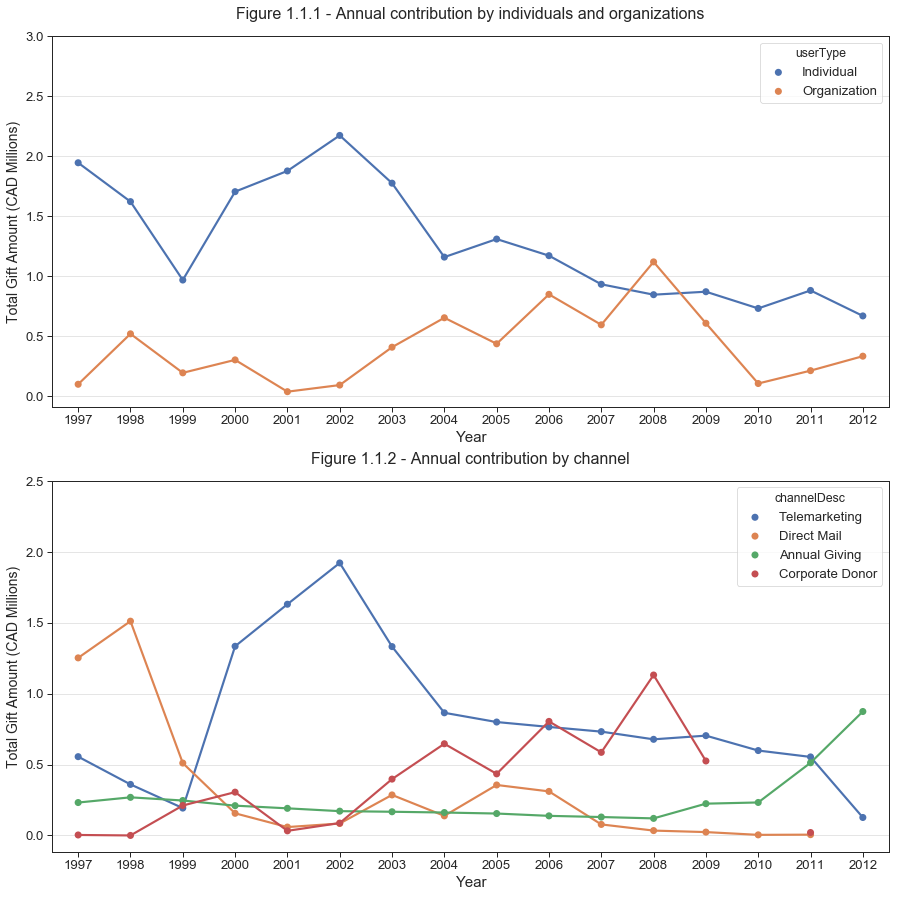

In [25]:
table1 = df.groupby(["year","userType"])["giftAmount_adj"].sum().reset_index()
table2 = df.groupby(["year","channelDesc"])["giftAmount_adj"].sum().reset_index()

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)

ax = sns.pointplot(x = "year",y= table1["giftAmount_adj"]/1000000, hue = "userType" ,data =table1)
plt.title("Figure 1.1.1 - Annual contribution by individuals and organizations", fontsize=16)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Total Gift Amount (CAD Millions)', fontsize=14)
plt.grid(axis='y' ,linestyle='-', linewidth=0.5)
ax.title.set_position([.5, 1.03])
plt.yticks(np.arange(0, 3.5, 0.5))

plt.subplot(2,1,2)

order = ['Telemarketing','Direct Mail', 'Annual Giving', 'Corporate Donor']

ax = sns.pointplot(x = "year",y= table2["giftAmount_adj"]/1000000, hue_order =order, hue = "channelDesc" ,data =table2)
plt.title('Figure 1.1.2 - Annual contribution by channel', fontsize=16)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Total Gift Amount (CAD Millions)', fontsize=14)
plt.grid(axis='y' ,linestyle='-', linewidth=0.5)
ax.title.set_position([.5, 1.03])
plt.yticks(np.arange(0, 3.0, 0.5))

plt.show()

Figure 1.1.1 describes the variation of the amount donated by individuals and companies from 1997 to 2012. We observe that individual participation in 1997 is predominant as this group was responsible for 95% of the total donated. Nevertheless, as time went by, donations from individuals started to decline from 1.9 MM CAD in 1997 to approximately 0.68 MM CAD in 2012.  Organizations, on the other hand, over the same period displayed a steady increase in donations until surpassing individual contributions in 2008, followed by a sharp decrease until 2010. 


Figure 1.1.2 describes the channel participation in donations for the same interval. The plot shows telemarketing as being the primary source of donations for most years from 2000 onwards. During this period a sharp decrease occurred in 2004 where roughly half the amount of 2002 was obtained. Telemarketing donations continued to fall steadily until 2012 when it was no longer the primary source of gifts, displaying only 0.12 MM in gift amount. 

Fluctuations in donation values from user type and channels over the years can be due to many reasons, such as variation in channel efficiency, in donor's behaviour and lastly due to different strategies adopted by the organization. As many of these aspects are not represented as features in our data nor were shared by the organization, we can only speculate reasons for some behaviours.

## 1.2) Telemarketing channel overview

As explained in the previous section the analysis will be focused on the telemarketing. The goal is to show the behaviour of some essential fundraising metrics exclusively for this channel and thus provide valuable insights to the organization.

Filters apllied to build the telemarketing dataset:

- Telemarketing channel
- Individuals userType only (Organizations contributed only to 0.5% of the total gift value)

In [26]:
tel_df = df[(df["userType"] =='Individual') & (df["channelDesc"] == "Telemarketing") ]
df_user = create_userDf(tel_df,"userId",'giftDate','giftAmount_adj','year', keep=["postalCode"])

In [27]:
tel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251433 entries, 0 to 440641
Data columns (total 18 columns):
userId              251433 non-null object
userType            251433 non-null object
postalCode          251361 non-null object
giftDate            251433 non-null datetime64[ns]
giftType            251433 non-null object
giftPaymentType     251433 non-null object
giftReceipt         251433 non-null object
giftCode            3915 non-null object
giftAmount          251433 non-null float64
channelId           251433 non-null object
channelDesc         251433 non-null object
year                251433 non-null int64
giftAmount2         251433 non-null float64
inflation_factor    251433 non-null float64
postal_FSA          251361 non-null object
giftAmount_adj      251433 non-null float64
giftAmount_cat1     251429 non-null object
giftAmount_cat2     251429 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(12)
memory usage: 36.4+ MB


In [28]:
tel_initial_date = tel_df["giftDate"].min()
tel_end_date = tel_df["giftDate"].max()
tel_n_donations = len(tel_df)
tel_n_users = tel_df['userId'].nunique()
tel_n_postalcodes = tel_df['postalCode'].nunique()

Basic info of the telemarketing dataset:

- The time interval ranges from from 1997-01-01 to 2012-12-31 (yyyy-mm-dd)
- 359034 total donations registered
- 107338 unique users
- 67204 unique postal codes
- 1 user types (Individuals)

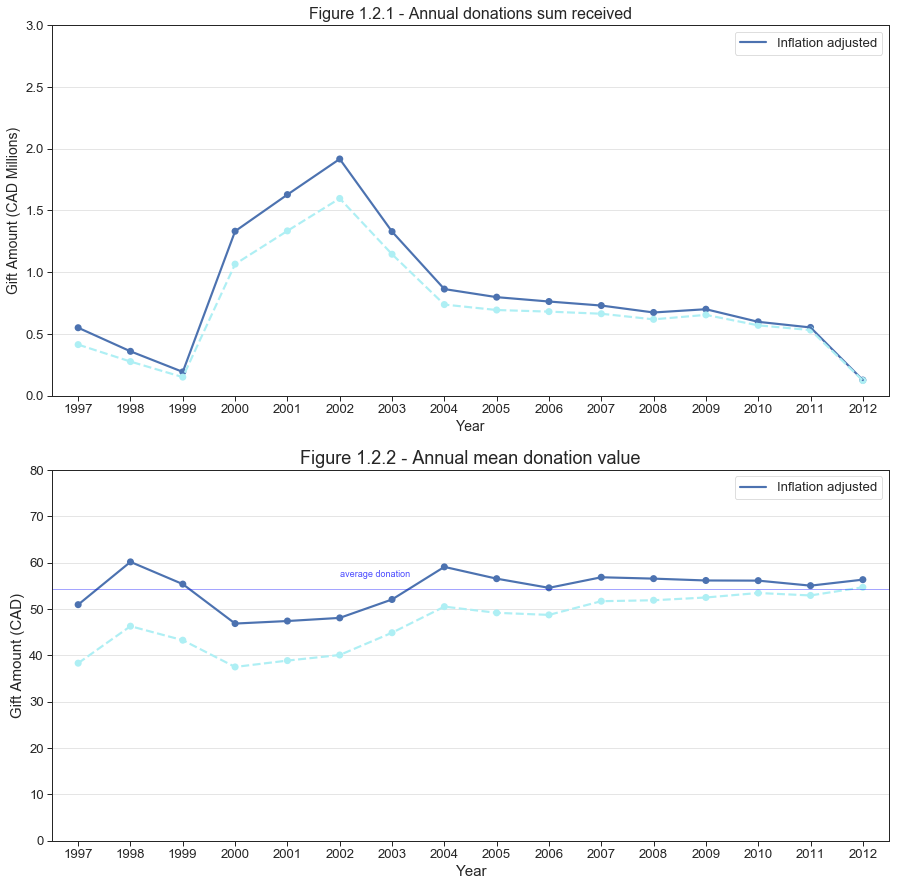

In [29]:
table1 = tel_df.groupby("year")[["giftAmount_adj",'giftAmount2']].sum().reset_index()
table2 = tel_df.groupby("year")[["giftAmount_adj",'giftAmount2']].mean().reset_index()


plt.figure(figsize=(15,15))
plt.subplot(2,1,1)

ax = sns.pointplot(x = "year",y =table1["giftAmount_adj"]/1000000, data =table1)
ax = sns.pointplot(x = "year",y =table1["giftAmount2"]/1000000, data =table1, color ='#AEEFF4',linestyles='--' )

plt.title("Figure 1.2.1 - Annual donations sum received", fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Gift Amount (CAD Millions)', fontsize=14)
plt.grid(axis='y' ,linestyle='-', linewidth=0.5)
plt.yticks(np.arange(0, 3.5, 0.5))
ax.legend(handles= ax.lines[::len(tel_df)+1], labels=['Inflation adjusted',"not adjusted"])

plt.subplot(2,1,2)

ax = sns.pointplot(x = "year",y =table2["giftAmount_adj"],data =table2)
ax = sns.pointplot(x = "year",y =table2["giftAmount2"], data =table2, color ='#AEEFF4',linestyles='--' )

plt.title("Figure 1.2.2 - Annual mean donation value", fontsize=18)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Gift Amount (CAD)', fontsize=15)
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 90, 10))

ax.legend(handles= ax.lines[::len(tel_df)+1], labels=['Inflation adjusted',"not adjusted"])


plt.axhline(y=table2["giftAmount_adj"].mean(), color = 'blue',linewidth= 0.5, alpha= 0.7)
ax.text(5, 57, "average donation", fontsize=9, color ="blue", alpha= 0.7)

plt.grid(axis='y' ,linestyle='-', linewidth=0.5)

plt.show()

Figure 1.2.1 shows the annual variation of the amount donated through telemarketing.  The dark blue and light blue line represents values adjusted and non-adjusted by the inflation factor respectively.

- Telemarketing donations value started relatively low in 1997 with only 0.55 MM; this value gradually lowered until 1999 accumulating only 0.25 MM in that year. Afterwards, a dramatical increase is observed until 2002 where the highest historical value of 1.9 MM was obtained. Next a sharp decrease until 2004 is noticed when the amount received diminished roughly two times to 0.86 MM. From this year onwards telemarketing revenues slowly decreased continuously.


- A higher count of campaigns was observed during 2001 and 2002 that could explain the peak observed in donations during this period. Nevertheless, more campaigns do not necessarily mean more phone calls.


- Since the telemarketing data was not provided, we cannot infer if more powerful campaigns took place during these years when peaks were observed. If we have had access to the number of successful call and non-successful calls we could verify the performance of these campaigns. 


Figure 1.2.2 exhibits the annual mean donation value. The dark blue and light blue line represents values adjusted and non-adjusted by the inflation factor over the years respectively. 

- The plot shows that this parameter remained approximately constant over time when the inflation factor is considered.  Small oscillations were observed during late 90's and early 2000s ranging from 60 CAD to 46 CAD. The average donation value from 1997 to 2012 is 54.22 CAD.


- Should the inflation factor had not been considered, we would have concluded (mistakenly) an increase in the average value donated over the years.


- Considering that different campaigns took place during this period, we could infer that they did not have an impact on the gift amount on average. 


- Currently, the average donation value is 56.30 CAD.

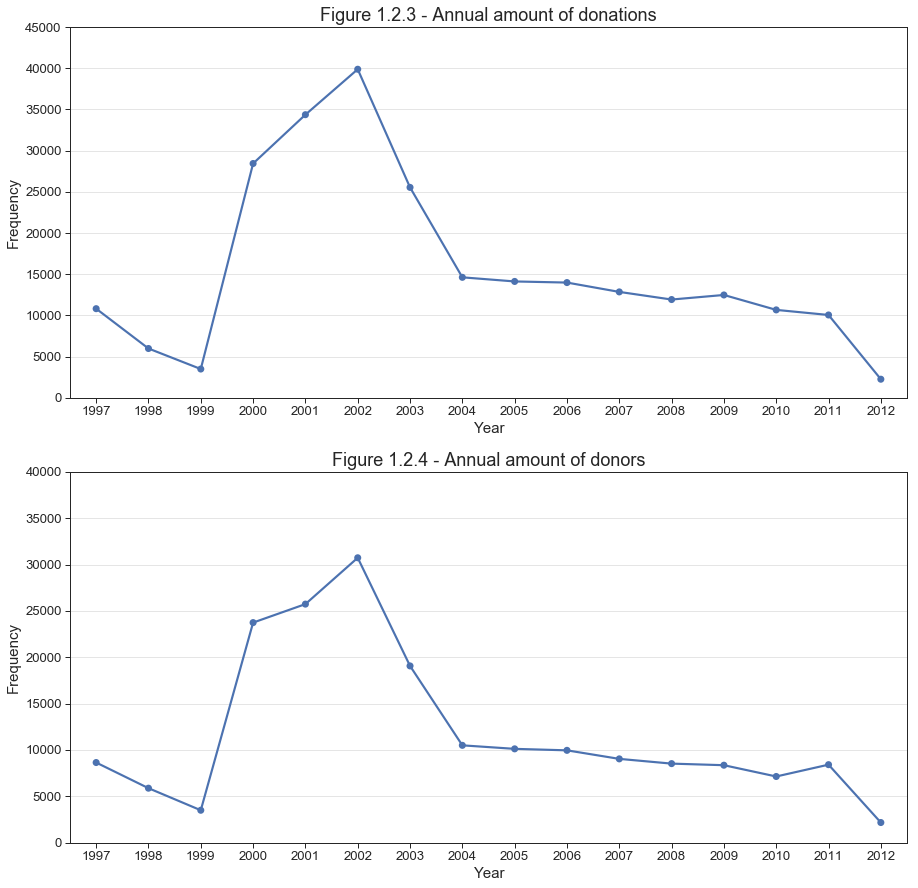

In [31]:
table1 = tel_df.groupby("year")["userId"].count().rename("frequency").reset_index()
table2 = tel_df.groupby("year")["userId"].nunique().rename("frequency").reset_index()

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)

ax = sns.pointplot(x = "year",y ="frequency",data =table1)
plt.title("Figure 1.2.3 - Annual amount of donations", fontsize=18)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.grid(axis='y' ,linestyle='-', linewidth=0.5)
plt.yticks(np.arange(0, 50000, 5000))

plt.subplot(2,1,2)

ax = sns.pointplot(x = "year",y ="frequency",data =table2)
plt.title("Figure 1.2.4 - Annual amount of donors", fontsize=18)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(np.arange(0, 45000, 5000))

plt.grid(axis='y' ,linestyle='-', linewidth=0.5)

plt.show()

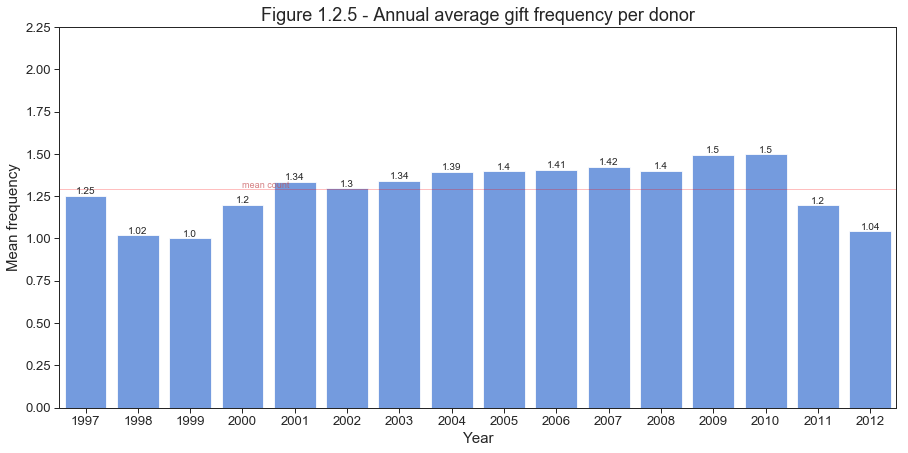

In [32]:
table = tel_df.groupby(["year","userId"])["userId"].count().rename('count').reset_index()
table = table.groupby("year")["count"].mean().reset_index()

plt.figure(figsize=(15,7))
ax = sns.barplot(x = 'year', y = 'count',data = table, ci =None, color ='#6296F0')

plt.title("Figure 1.2.5 - Annual average gift frequency per donor", fontsize=18)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean frequency', fontsize=15)
plt.yticks(np.arange(0, 2.5, 0.25))

plt.axhline(y=table['count'].mean(), color = 'red',linewidth= 0.5, alpha= 0.5)
ax.text(3, 1.3, "mean count", fontsize=9, color ="r", alpha= 0.7)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.01,
            np.nan_to_num(np.round(height,2)),
            ha="center")


plt.show() 

Figure 1.2.3 shows the annual variation of donation frequency. 
- We observe the same trend of figure 1.2.1 showing that revenues decreased in the same ratio as the number of donations decreased. This finding is in agreement with figure 1.2.2 which demonstrate a roughly constant mean value donated over the years. 


Figure 1.2.4 displays the annual variation of unique donors.
- We once again note the same pattern. From this, we can deduce that the rise observed on donations count (and consequently on revenues) came from more donors rather than an increase in their donations frequency. 


Figure 1.2.5 exhibits the average frequency of gifts by donors each year (Example: In 2001 donors donated on average 1.8 times). 
- From 2001 to 2008 the parameter remained approximately constant. We observe the highest historical value of 1.5 in 2009 and 2010, followed by a significant fall to 1.0 in 2012.  


- Lower gift frequency by donors may also explain why revenues in 1998 and 2012 were lower. Not only there were fewer donors, but also the rate of donations was reduced by each contributor on average.  

To enhance our understanding a new dataset was built considering a 'user' perspective. This dataset aggregates all information of the donations by user ID to create new important variables and it was also necessary to display some of the fundraising metrics.

Variables created for the 'df_user' dataset:

**first_gift_date** - Date of first gift     
**last_gift_date** - Date of last gift   
**first_gift_year** - Year of first gift  
**last_gift_year**  - Year of last gift  
**first_gift_amount** - First gift value   
**total_donated** - Total donated within the donor's lifespan   
**std_donated** - Standard deviation of donations values      
**average_donated**  - Mean value of donations  
**donation_count** - Count of donations   
**max_donation_gap** - Maximum interval in days observed between donations  
**min_donation_gap** - Minimum interval in days observed between donations  
**lifespan_total** - Donor's lifespan (Time between first and last gift in days, inactive time during lapses are considered)   
**lapses_count** - Number of lapses (A lapse is considered when a donor contibuted last year but did not give again this year)  
**current_active** - Indicates if the donor is current active in the time of reference (If he donated in the year of 2017 or/and 2018)  
**one_timer** - Indicates whether the donor is a 'one-timer donor' or a 'repeat donor'.    
**donation_rate** - Indicates the average time in days between donations.   
**donation_segment** - Indicates the donation segment the donor belongs (average value of all donations during his entire lifespan).



The table below shows a sample of the 'user' dataset

In [46]:
df_user.head(8)

,userId,first_gift_date,last_gift_date,first_gift_year,last_gift_year,first_gift_amount,total_donated,std_donated,average_donated,donation_count,min_donation_gap,max_donation_gap,donation_rate,lifespan_total,lapses_count,current_active,one_timer,donation_segment,postalCode
0,10000,1998-09-15,1998-09-15,1998,1998,18.2000,18.2000,NaN,18.200000,1.0,0.0,0.0,0.0,0,1,0,1,1-25 CAD,M4S 1B4
1,100002,1997-04-10,1997-10-11,1997,1997,49.5425,73.4825,18.103701,36.741250,2.0,184.0,184.0,92.0,184,1,0,0,26-50 CAD,L6W 4L9
2,100003,2000-05-02,2002-06-18,2000,2002,47.5000,175.3240,55.936401,58.441333,3.0,357.0,420.0,259.0,777,1,0,0,51-100 CAD,K0H 2S0
3,100015,1997-03-26,2002-09-07,1997,2002,11.0390,188.2800,11.096371,17.116364,11.0,56.0,765.0,181.0,1991,2,0,0,1-25 CAD,K2J 1T2
4,100016,2000-06-13,2003-05-01,2000,2003,61.2500,110.4340,8.531950,55.217000,2.0,1052.0,1052.0,526.0,1052,2,0,0,51-100 CAD,M4K 2J5
5,10002,1998-01-17,1998-01-17,1998,1998,41.8600,41.8600,NaN,41.860000,1.0,0.0,0.0,0.0,0,1,0,1,26-50 CAD,M3N 1S7
6,100032,2000-11-07,2001-01-30,2000,2001,105.4375,246.3475,25.082845,123.173750,2.0,84.0,84.0,42.0,84,1,0,0,101-250 CAD,M4R 1J7
7,100033,1997-07-18,1997-07-18,1997,1997,30.7230,30.7230,NaN,30.723000,1.0,0.0,0.0,0.0,0,1,0,1,26-50 CAD,V3N 1Z9


The **Donor Lifetime Value (LTV)** is a prediction of how much money you can expect to receive from a donor during the lifetime of their giving (From the first donation to the last donation). Donor lifetime value is a prediction.

Calculation of Lifetime value :

**LTV = Lifespam * Average donation amount * Frequency of donation**

The calculation of LTV is segmented by the donation category the donor belongs.
(1-25 CAD, 26-50 CAD, 51-100 CAD, 101-250 CAD, 251-500 CAD, over 500 CAD)

**The following premises have been  adopted to calculate these variables:**

1) Donor lifespan: Estimated considering the average time a donor maintains a relationship with the organization varying according only to their donation category.

2) Average donation amount: Varies according to the donor's donation segment and year.  

3) Frequency of donation: Varies according to the donor's donation segment and year. 

If the costs associated with the telemarketing channel hab been given it would have been possible to calculate te return of investment (ROI) for each segment using the information from the LTV. 

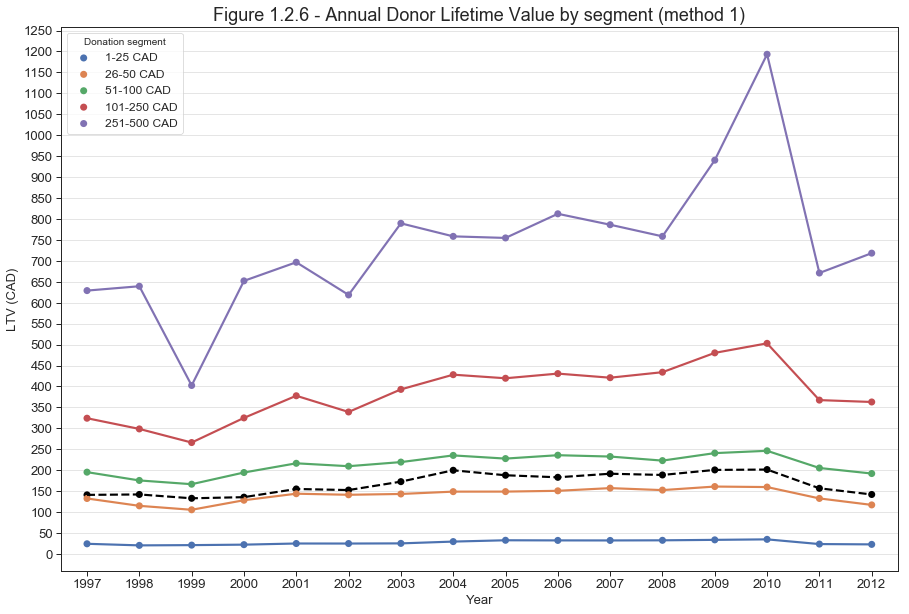

In [34]:
LTV_table = LTV(tel_df,df_user,'userId','year','giftAmount_adj')
ave_table = LTV_table.groupby("year").apply(lambda x: np.average(x['LTV'], weights=x['donation_count'])).rename("mean_LTV").reset_index()

plt.figure(figsize=(15,10))
    
order =['1-25 CAD','26-50 CAD','51-100 CAD','101-250 CAD','251-500 CAD']

ax = sns.pointplot(x="year", y="mean_LTV", data = ave_table,linestyles='--', color = 'black')
ax = sns.pointplot(x="year", y="LTV", hue = "donation_segment", hue_order = order, data = LTV_table)


plt.title("Figure 1.2.6 - Annual Donor Lifetime Value by segment (method 1)", fontsize=18)

plt.yticks(np.arange(0, 1300,50))
plt.legend(fontsize = 12,title= "Donation segment")

plt.xlabel('Year', fontsize=13)
plt.ylabel('LTV (CAD)', fontsize=13)

plt.grid(axis='y' ,linestyle='-', linewidth=0.5)

plt.show()

Figure 1.2.6 Shows the Donor Lifetime value by donation per year. (Example: donors who belong to the '51 to 100 CAD'  segment in 2008 was expected to return 225 CAD to the organization throughout his lifespan.

- As expected donors belonging to higher donations categories have a higher LTV.


- Higher donations segments tend to oscillate more due to a fewer number of observations. Also, the average donated within these groups tends to fluctuate more. 


- The average LTV tends to oscillate around 150 CAD as the majority of donors belongs to lower donations segments. This value tends to be steady showing that donor's behaviour in terms of lifespan, average donated and frequency combined does not change dramatically over time.



The **Donor Retention Rate** is the number of donors you keep with respect to the number you had at the start of a given period. It does not consider new donors, but it will consider upgraded and downgraded donors. In this work, a donor is retained if he donated for two consecutive years

**Donor Retention Rate = (Retained Donors / All Donors) *100 **


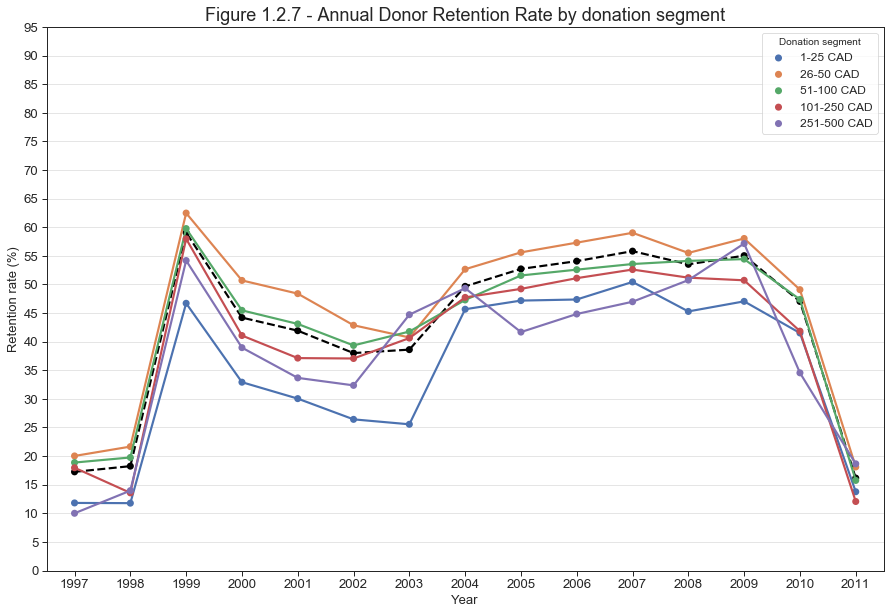

In [35]:
table_dr1, table_dr2 = donor_retention(tel_df,df_user,'userId','year')

plt.figure(figsize=(15,10))

order =['1-25 CAD','26-50 CAD','51-100 CAD','101-250 CAD','251-500 CAD']

ax = sns.pointplot(x="year", y='retention_rates', data = table_dr1, linestyles='--', color ='black')
ax = sns.pointplot(x="year", y='retention_rates', hue = "donation_segment", hue_order = order, data = table_dr2)

#ax.lines[0].set_linestyle("--")

plt.title("Figure 1.2.7 - Annual Donor Retention Rate by donation segment", fontsize=18)


plt.yticks(np.arange(0, 100,5))
plt.legend(fontsize = 12,title= "Donation segment")
plt.xlabel('Year', fontsize=13)
plt.ylabel('Retention rate (%)', fontsize=13)

plt.grid(axis='y' ,linestyle='-', linewidth=0.5)

plt.show()

Figure 1.2.7 Exhibits the Donor Retention Rate by donation segment. (Example: 39% of the donors belonging to the '51-100 CAD' category in 2002 also donated in 2003.

- We observe that all donations segments have a similar pattern over the years. We can assume that donors from different segments present the same behaviour due to the retention strategy being used. 


- The average retention varies a lot over the years showing that donors numbers may differ significantly over the years. This observation is in agreement with figure 1.2.4 where we examine that the years with the least amount of donors in years 1999 and 2012 also presented small retention rates of around 15%, corresponding to 1998 and 2011 in figure 1.2.7.


- The high variation of the donation rate is probably due to the amount of campaings and/or different strategies adopted each year. 


An **upgraded donor** is a retained donor who belongs to a higher donation segment in this year than last in the last year, while a **downgraded donor** is a retained donor who fell to a lower donation segment.

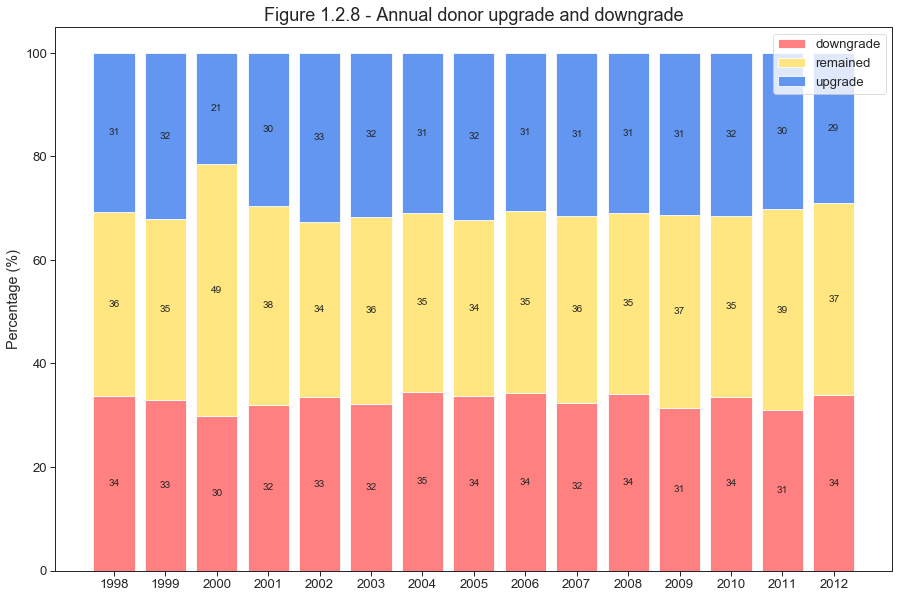

In [36]:
table_grade = up_down_grade(tel_df,'userId','year','giftAmount_adj')

data = [table_grade['downgrade_ratio'],table_grade['remained_ratio'], table_grade['upgrade_ratio']]
cat_labels = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
ser_labels = ['downgrade','remained','upgrade']

stacked_bar(data,series_labels =ser_labels ,category_labels = cat_labels,show_values=True,value_format="{:.0f}",y_label="Percentage (%)",
            grid =False, colors =['#ff8080','#ffe680','#6296F0'], title ="Figure 1.2.8 - Annual donor upgrade and downgrade")

Figure 1.2.8 displays the percentage of donors who upgraded, downgraded and remained in their donation segment each year. (Example: In 2001, 38% of the retained donors from 2005 remained in their donation segment, while 30% upgraded to higher segments and 32% downgraded to lower ones).

- The percentages of all three categories present approximately consistent behaviour. The only outlier observed was observed in 2000, where 49% of the retained donors remained in their donation segment.

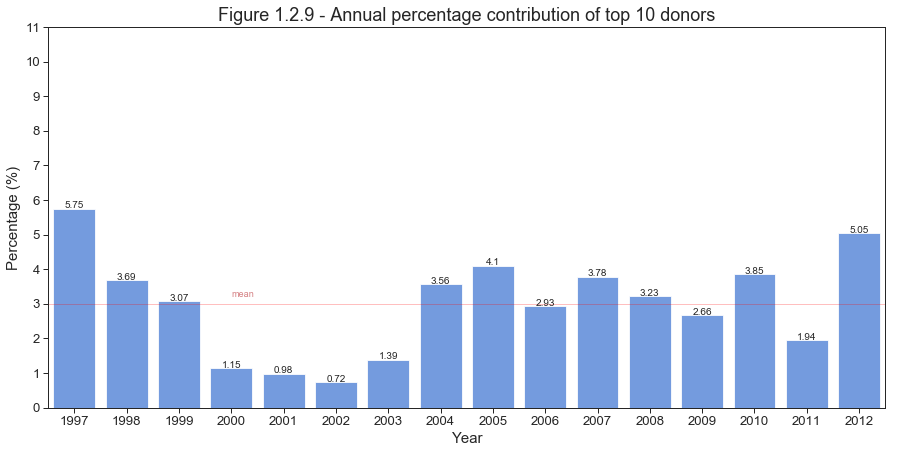

In [37]:
table1 = tel_df.groupby(["year","userId"])['giftAmount_adj'].sum().reset_index()
table1 = table1.sort_values(['year','giftAmount_adj'], ascending = [True,False])
table2 = (table1.groupby(['year'])['giftAmount_adj'].apply(lambda x: x[:10].sum())/table1.groupby(['year'])['giftAmount_adj'].sum()*100).reset_index()
table2.rename(columns ={'giftAmount_adj':'percentage_top10'},inplace =True)

plt.figure(figsize=(15,7))
ax = sns.barplot(x = 'year', y = 'percentage_top10',data = table2, ci =None, color ='#6296F0')

plt.title("Figure 1.2.9 - Annual percentage contribution of top 10 donors", fontsize=18)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Percentage (%)', fontsize=15)
plt.yticks(np.arange(0, 12, 1))

plt.axhline(y=table2['percentage_top10'].mean(), color = 'red',linewidth= 0.5, alpha= 0.5)
ax.text(3,3.2, "mean", fontsize=9, color ="r", alpha= 0.7)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.01,
            np.nan_to_num(np.round(height,2)),
            ha="center")

plt.show()

Figure 1.2.9 Shows the annual percentage contribution of the top 10 donors for a particular year. (Example: in 2012 the top 10 donors contributed to 5.05% of the total gift value received from the telemarketing)

- We observe that the top 10 major donors played a significant role in funding the organization through telemarketing. Numbers of donors ranged from 5000 to 10000 every year since 2004 according to figure 1.2.4. 


- It is recommended to check the nature of these donations as some of them are over 30000 CAD. It was observed that the top 10 major donors from all time had donated a total amount varying from 8400 CAD to 42000 CAD throughout their lifespan  in telemarketing only.

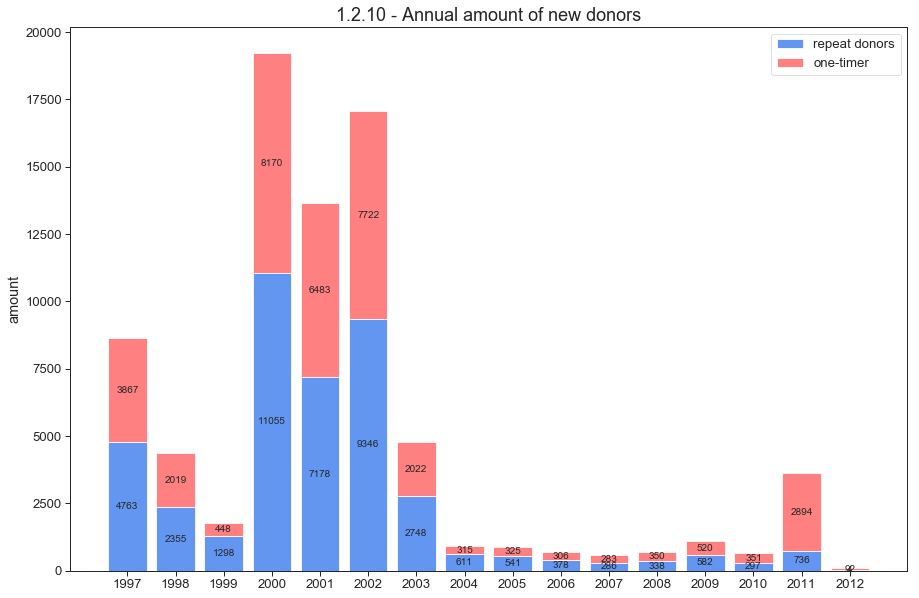

In [38]:
data = [df_user[df_user["one_timer"] == 0].groupby("first_gift_year")["userId"].count(),
        df_user[df_user["one_timer"] == 1].groupby("first_gift_year")["userId"].count()]

cat_labels = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
ser_labels = ['repeat donors','one-timer']

stacked_bar(data,series_labels = ser_labels ,category_labels = cat_labels,show_values=True,value_format="{:.0f}",y_label="amount",
            grid =False, colors = ['#6296F0','#ff8080'], title ="1.2.10 - Annual amount of new donors")

Figure 1.2.10 displays the annual amount of new donors that enters the database. (Example: In 2001 the organization received 13661 new donors of which 7178 were 'repeat donors' (Donated more than one time) and 6483 were one-timers (Donated only once).

 - We observe peaks of new donors entering the base from 2000 to 2003, probably as a result of acquisitions of donors bases.   From 2004 onwards new donors enter the base on a steady rate of roughly new 700 donors per year. The peaks observed are in agreement with figure 1.2.4.
  
- 58% of all donors are repeat donors are 42% are one-timers over the entire period. 


- Percentages of one-timers tend to be constant between 40-50%  every year.

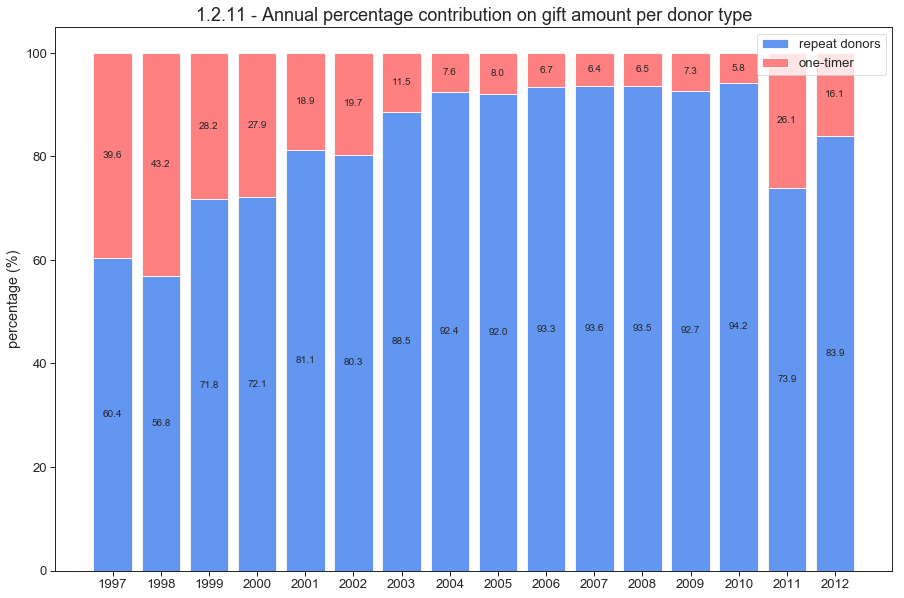

In [49]:
table1 = df[['userId','year','giftAmount_adj']].merge(df_user[['userId','donation_segment','one_timer']],'inner',on ='userId')

data =[table1[table1["one_timer"] == 0].groupby('year')['giftAmount_adj'].sum()/table1.groupby('year')['giftAmount_adj'].sum()*100,
       table1[table1["one_timer"] == 1].groupby('year')['giftAmount_adj'].sum()/table1.groupby('year')['giftAmount_adj'].sum()*100]

cat_labels = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
ser_labels = ['repeat donors','one-timer']

stacked_bar(data,series_labels = ser_labels ,category_labels = cat_labels,show_values=True,value_format="{:.1f}",y_label="percentage (%)",
            grid =False, colors = ['#6296F0','#ff8080'], title ="1.2.11 - Annual percentage contribution on gift amount per donor type")

Figure 1.2.11 Exhibits the percentage contribution of each donor type in the gift amount for each year. (Example: In 2009 92.7% of the total donated came from repeat donors, while 7.3% from one-timers). It is important to mention that these percentages include new donors for the particular year and repeat donors from previous years.

- We observe that the contribution of repeat donors represent roughly 86% of the total donations on average for the entire period indicating how important this type of user is to the organization.


- It is highly recommended to analyze more in-depth the characteristics of these two types of donors to focus campaigns in the repeat type profile.

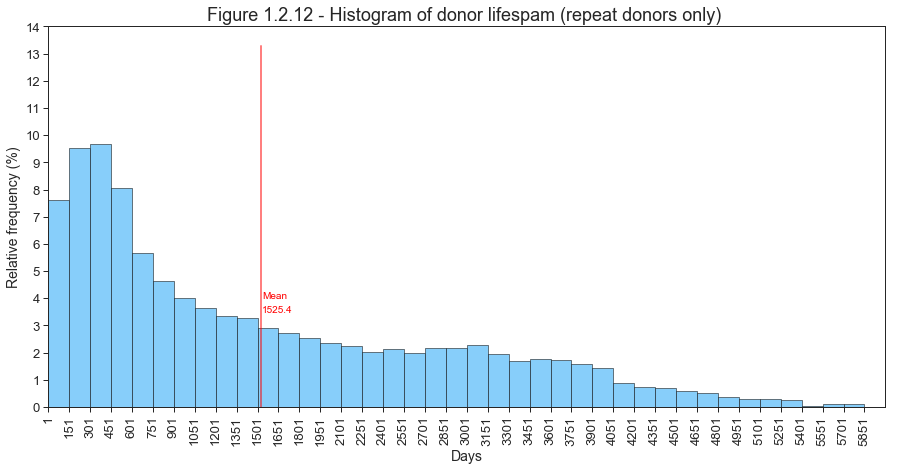

In [40]:
plt.figure(figsize=(15,7))

array2 = df_user[df_user["lifespan_total"] !=0]["lifespan_total"]

plt.hist(array2, bins =np.arange(1,6000,150),color ="lightskyblue" , 
    weights = np.ones_like(array2)/float(len(array2))*100, edgecolor='black', linewidth=0.5)

plt.yticks(np.arange(0, 15, 1))
plt.title("Figure 1.2.12 - Histogram of donor lifespam (repeat donors only) ", fontsize=18)
plt.ylabel('Relative frequency (%)', fontsize=14)
plt.xticks(np.arange(1,6000,150))
plt.xlim ([1,6000])
plt.xlabel('Days', fontsize=14)

plt.axvline(x=array2.mean(), color = 'red',linewidth= 2, alpha= 0.5,ymax =0.95)
plt.annotate("Mean" , xy=(2, 4), xytext = (array2.mean() + 10, 4), color ="red")
plt.annotate(np.round(array2.mean(),1) , xy=(2, 4.7), xytext=(array2.mean()+ 10, 3.5), color ="red")
plt.xticks(rotation=90)

plt.show()

Figure  1.2.12 shows the histogram of lifespan in days for repeat donors only (one-timers have a lifespan of 0). (Example: 9.5 % of repeat donors have a lifespan of 151 to 300 days)

- The average lifespan for repeat donors is 1525 days (4.17 years). Note that some donors may have lapsed and returned within this period.


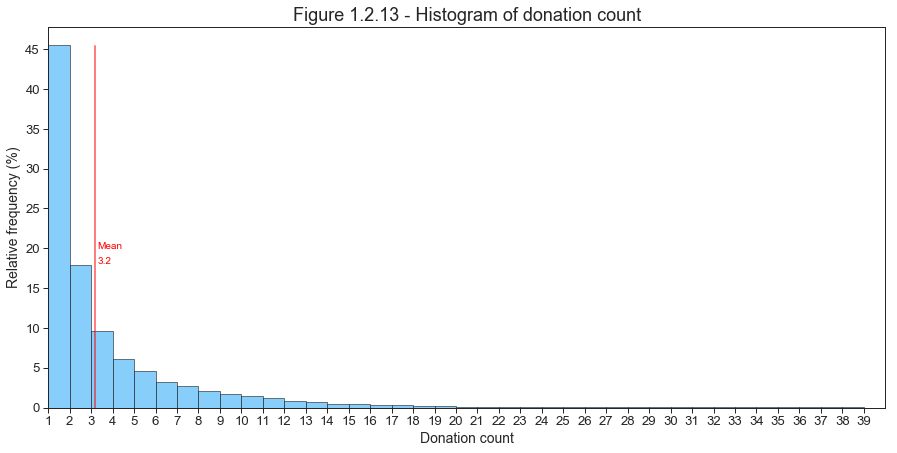

In [41]:
plt.figure(figsize=(15,7))

array2 = df_user["donation_count"]

plt.hist(array2, bins =np.arange(1,40,1),color ="lightskyblue" , 
    weights = np.ones_like(array2)/float(len(array2))*100, edgecolor='black', linewidth=0.5)

plt.yticks(np.arange(0, 50, 5))
plt.title("Figure 1.2.13 - Histogram of donation count", fontsize=18)
plt.ylabel('Relative frequency (%)', fontsize=14)
plt.xticks(np.arange(1,40,1))
plt.xlim ([1,40])
plt.xlabel('Donation count', fontsize=14)

plt.axvline(x=array2.mean(), color = 'red',linewidth= 2, alpha= 0.5,ymax =0.95)
plt.annotate("Mean" , xy=(2, 4), xytext = (array2.mean() + 0.08, 20), color ="red")
plt.annotate(np.round(array2.mean(),1) , xy=(2, 4.7), xytext=(array2.mean()+ 0.08, 18), color ="red")


plt.show()

Figure 1.2.13 displays the histogram of donation count of donors. (Example: 17.5% of donors donated two times in his entire lifespan)

- The average donations count from repeat and one-timers is 3.2 donations.

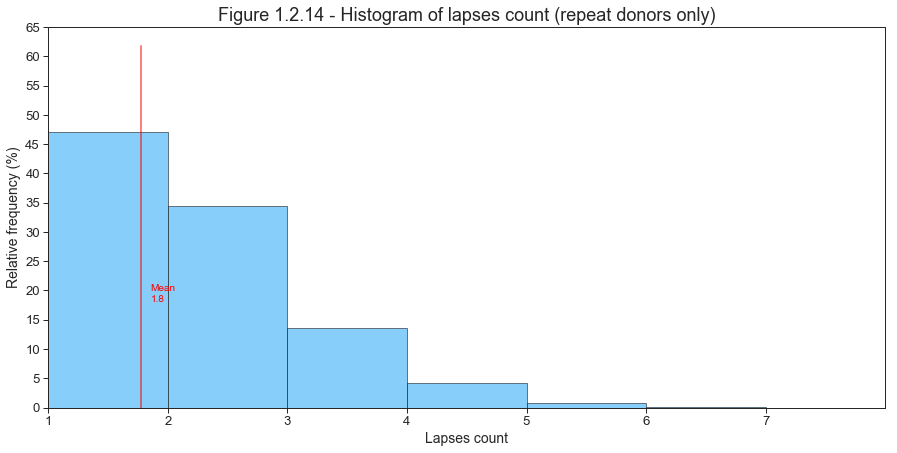

In [42]:
plt.figure(figsize=(15,7))

array2 = df_user[df_user["one_timer"] !=1]["lapses_count"]

plt.hist(array2, bins =np.arange(1,8,1),color ="lightskyblue" , 
    weights = np.ones_like(array2)/float(len(array2))*100, edgecolor='black', linewidth=0.5)

plt.yticks(np.arange(0, 70, 5))
plt.title("Figure 1.2.14 - Histogram of lapses count (repeat donors only)", fontsize=18)
plt.ylabel('Relative frequency (%)', fontsize=14)
plt.xticks(np.arange(1,8,1))
plt.xlim ([1,8])
plt.xlabel('Lapses count', fontsize=14)

plt.axvline(x=array2.mean(), color = 'red',linewidth= 2, alpha= 0.5,ymax =0.95)
plt.annotate("Mean" , xy=(2, 4), xytext = (array2.mean() + 0.08, 20), color ="red")
plt.annotate(np.round(array2.mean(),1) , xy=(2, 4.7), xytext=(array2.mean()+ 0.08, 18), color ="red")


plt.show()

Figure 1.2.14 displays the histogram of lapses count for repeat donors only (one-timers have necessarily the value of 1). (Example: 47.5% of repeat donors have lapsed only once)

- The average lapse count from repeat donors is 1.8 times.

### Preliminary conclusions 

- Telemarketing is losing importance over the years for other channels. Reduction in acquisition of new donors and migration of telemarketing donors to annual giving are some of the reasons.


-  Inflation factor must be considered for more accurate analysis considering that a long period is being studied.


- Average value of telemarketing donations has not changed significantly over the years. These may be the result of consistent and unchanged approach with donors.


- The average LTV (Lifetime value) tends to oscillate around 150 CAD as the majority of donors belongs to lower donations segments. The calculation of the LTV may be reviewed as simple premisses were used to predict this metric.


- Retention rate varies a lot over the years, from 12% to 60%, as a result donors numbers may differ significantly over the years. This is probably due to a different number of campaigns or strategies adopted each year.


- Percentages of upgraded and downgraded donors present consistent behaviour over the years. On average 30%, 33% and 33% of retained donors upgrade, remain and downgrade respectively in the following year.


- We observe that top 10 major donors played a significant role in funding the organization through telemarketing annualy. It is recommended to check the nature of these donations as some of them are over 30000 CAD.


- We observe peaks of new donors entering the base as a result of acquisitions of donors bases. 58% of all donors are repeat donors are 42% are one-timers over the entire period. Repeat donors represent roughly 86% of the total donation amount received.

**Recommendations of future analysis for telemarketing:**

1) Verify the performance of the telemarketing campaigns to determine better strategies to contact donors according to their profile. (For example weekday and time to call a donor).Call center data is needed. 

2) Determine the return of the investment (ROI) of each channel. Costs involved from each channel are needed.

3) Demographics studies. The donations dataset provides the postal code of each user, thus it is possible to find the best locations to seek donors. 

4) Verify the influence of the channels on the others.

5) Understand behaviour and profile of one-timers and repeat donors.

6) Create a model to predict the probability of a donor to lapse in a given time using machine learning techniques. In order to this we need to get more variables from the organization. These may include donor profile information and/or call center data for example.